In [16]:
import matplotlib.pyplot as plt
import numpy as np

"""In order to provide a better presentation of the graphs we use the rcParams options shown below."""

import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

In [17]:
import numpy as np
import matplotlib.pyplot as plt


import time
from scipy.integrate import odeint
from scipy.special import zeta
from random import choices

In [18]:
"""Our system of differential equations belongs to the complex space, that is why we implemented the code suggested in"""
"""https://stackoverflow.com/questions/19910189/scipy-odeint-with-complex-initial-values."""

import time
import numpy as np
from scipy.integrate import odeint
from scipy.special import zeta
from random import choices

def odeintz(func, z0, t, **kwargs):
   
    
    """An odeint-like function for complex valued differential equations.

    Inputs:
    ----------
      -func: function associated to dr/dt=f(x;t), where x is the set of parameters and variables to be determined
      -z0: 1d array with length N*(5N-1)/2
      -t: 1d array from t=0 to t=tf (parameter set by the user)
      - **kwargs: keyword arguments related with external functions to be used in odeint
    
    Return:
      -z: multivariable array with the solution of the differential equation associated with each variable"""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


dt = 0.001 # Time step.
T = 3 # Total time.
n = int(T / dt) # Number of time steps.

J=1
N=40

refgamma=0.2  #Fixed
refdecay=0
refomega=1

Gamma_du=0  #Fixed
Gamma_phi=refgamma*J
Gamma_decay=refdecay*J
Omega=refomega*J

sqrt_2phi=  (2*Gamma_phi)**0.5
sqrt_decay= (Gamma_decay)**0.5


Stochastic=1   #Is the process stochastic?

sqrt_Gamma_phi = np.sqrt(Gamma_phi)
sqrtdt = np.sqrt(dt)*Stochastic

from numba import jit

@jit

def trayectory(N=N):


    Results =np.zeros((3*N, n))

    for j in range(N):
        a=(choices([-1,1]))[0]
        b=(choices([-1,1]))[0]
        Results[j][0]=a   #state |+>
        Results[j+N][0]=b
        Results[j+2*N][0]=-1


    for t in range(n-1):
        for i in range(N): 
            Normal_VA=np.random.randn()#np.random.normal(0, 1)
        
            Results[i][t+1]     = Results[i][t]+dt*(-Gamma_phi-(Gamma_decay/2) )*Results[i][t]-\
                (sqrt_2phi+sqrt_decay ) *Results[i+N][t]* sqrtdt * Normal_VA
            Results[i+N][t+1]   = Results[i+N][t]+dt*(-Omega*Results[i+2*N][t] -(Gamma_phi+ (Gamma_decay/2))*Results[i+N][t])+\
                (sqrt_2phi+sqrt_decay ) *Results[i][t]* sqrtdt * Normal_VA
            Results[i+2*N][t+1] = Results[i+2*N][t]+dt*( Omega*Results[i+N][t] - Gamma_decay*(Results[i+2*N][t]+1) )+\
                sqrt_decay*(Results[i+2*N][t]+1)*sqrtdt * Normal_VA
            
            for j in range(N):
                if i!=j:
                    Results[i][t+1]=Results[i][t+1]-2*Results[i+N][t]*(J/N)*Results[j+2*N][t]*dt
                    Results[i+N][t+1]=Results[i+N][t+1]+ 2*Results[i][t]*(J/N)*Results[j+2*N][t]*dt
                    
                    
            
            
    return Results


In [36]:
from numba import jit

@jit

def averages(itera,N):
    
    Average=np.zeros((3*N, n))
    for j in range(itera):
        Average=np.add(Average,trayectory(N))
    return Average/itera
    

In [37]:
t0=time.time()

Iterations=10000


Result=averages(Iterations,N)


t1=time.time()

print(t1-t0)

<ipython-input-36-59a73b6f0605>:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "averages" failed type inference due to: Invalid use of type(CPUDispatcher(<function trayectory at 0x0000028ABAA2FA60>)) with parameters (int64)

During: resolving callee type: type(CPUDispatcher(<function trayectory at 0x0000028ABAA2FA60>))
During: typing of call at <ipython-input-36-59a73b6f0605> (9)


File "<ipython-input-36-59a73b6f0605>", line 9:
def averages(itera,N):
    <source elided>
    for j in range(itera):
        Average=np.add(Average,trayectory(N))
        ^

  @jit
<ipython-input-36-59a73b6f0605>:3: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "averages" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-36-59a73b6f0605>", line 8:
def averages(itera,N):
    <source elided>
    Average=np.zeros((3*N, n))
 

320.9494743347168


In [38]:
#from numba import jit

#@jit

def Sk(value):
    
    if value==0:  
        Sx=Result[0]
        for j in range(1,N):
            Sx=np.add(Sx,Result[j])
        return Sx/2
    elif value==1:
        Sy=Result[N]
        for j in range(1,N):
            Sy=np.add(Sy,Result[j+N])
        return Sy/2
    elif value==2:
        Sz=Result[2*N]
        for j in range(1,N):
            Sz=np.add(Sz,Result[j+2*N])
        return Sz/2
    


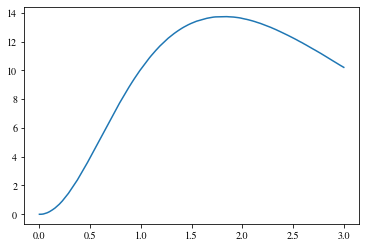

In [39]:
times = np.linspace(0., T, n)
plt.plot(times,Sk(0))

In [40]:




gammaplus=Gamma_du/2
gammaminus=Gamma_decay/2
gammaz=Gamma_phi/4


Gamma=np.array([gammaplus,gammaminus,gammaz])  #[gamma+,gamma-,gammaz]


### Initial State

"""We consider by defect that the system starts in |0> for all the spins. The user can set the initial state as well."""
"""Recall that |0><0|=[[1,0],[0,0]]  """

"""The benchmark suggests that our initial state should be |psi(0)>=|+>"""


#t0=time.time()



def trace(A):
    return np.trace(A)

def matmu(A,B):
    return np.matmul(A,B)


rho_init0=np.array([[0,0],[0,1]])    #density matrix |1><1|
rho_init1=np.array([[0,0],[0,1]])    #density matrix |1><1|



#rho_init1=np.array([[1,0],[0,0]])    #By default
#rho_init2=np.array([[1,0],[0,0]])    #By default


sigma_p= np.array([[0,1],[0,0]])
sigma_m= np.array([[0,0],[1,0]])
sigma_z= np.array([[1,0],[0,-1]])


##Initial values one operator

sp_init0=trace(matmu(rho_init0,sigma_p))
sz_init0=trace(matmu(rho_init0,sigma_z))
sp_init1=trace(matmu(rho_init1,sigma_p))
sz_init1=trace(matmu(rho_init1,sigma_z))
sm_init1=trace(matmu(rho_init1,sigma_m))


##Initial values two-operators
## We assume initial separability of the state
#p0, z0, p1, z1 , p0p1, p0m1, z0p1, p0z1, z0z1 = z


sp_initp0p1=sp_init0*sp_init1
sz_initp0m1=sp_init0*sm_init1
sp_initz0p1=sz_init0*sp_init1
sz_initp0z1=sp_init0*sz_init1
sz_initz0z1=sz_init0*sz_init1




z0=np.array([sp_init0,sz_init0,sp_initp0p1,sz_initp0m1,sp_initz0p1,sz_initz0z1])



#t1=time.time()

#print(t1-t0)

#t0=time.time()

def cj(z): 
    return z.conjugate()

def real(z): 
    return z.real

def imag(z): 
    return z.imag


def dot_p(v1,v2):
    return np.dot(v1,v2)

from numba import jit

@jit

    # Define the right-hand-side of the differential equation.
def zfunc(z, t):
    p0, z0, p0p1, p0m1,   z0p1, z0z1 = z        
     
    
        
    dp0dt=-1j*(Omega/2)*z0+2*1j*(J/N)*(N-1)*z0p1    -(Gamma[0]+Gamma[1]+4*Gamma[2])*p0
        
    dz0dt= 2*Omega*np.imag(p0)+2*(Gamma[0]-Gamma[1])-2*(Gamma[0]+Gamma[1])*z0  
        
    dp0p1dt=-1j*Omega*z0p1+4*1j*(J/N)*(N-2)*(p0p1*z0+2*(z0p1-p0*z0)*p0)    -2*(Gamma[0]+Gamma[1]+4*Gamma[2])*p0p1

    dp0m1dt=-Omega*np.imag(z0p1)-2*(Gamma[0]+Gamma[1]+4*Gamma[2])*p0m1

    dz0p1dt=-1j*(Omega/2)*(2*(p0p1-p0m1)+z0z1)+  2*1j*(J/N)*( p0 + (N-2)*(z0z1*p0+2*(z0p1-z0*p0)*z0) )+2*(Gamma[0]-Gamma[1])*p0   
    dz0p1dt=dz0p1dt -(3*(Gamma[0]+Gamma[1])+4*Gamma[2])*z0p1
            
    dz0z1dt=  4*Omega*np.imag(z0p1)    - 4*(Gamma[1]-Gamma[0])*z0-4*(Gamma[0]+Gamma[1])*z0z1
        
        
        
        
    return [dp0dt, dz0dt, dp0p1dt, dp0m1dt, dz0p1dt, dz0z1dt] 

    # Set up the inputs and call odeintz to solve the system.

z, infodict = odeintz(zfunc, z0, times, full_output=1)
    
#t1=time.time()
#print(t1-t0)

C:\Users\camil\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


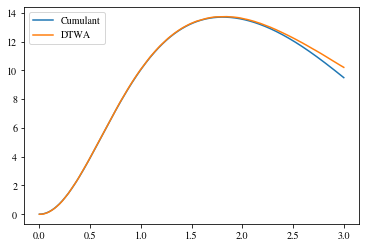

In [41]:
plt.plot(times,(N/2)*(z[:,0]+np.conjugate(z[:,0])),label="Cumulant")
plt.plot(times,Sk(0),label="DTWA")

#plt.plot(t, (N/2)*np.exp(-Gamma_phi*t)*(np.cos(2*J*t/N))**(N-1),label="Analytic")

plt.legend()

C:\Users\camil\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


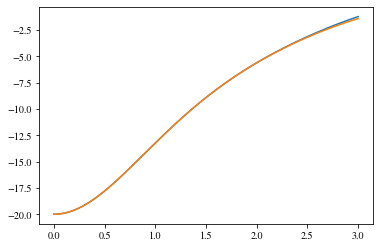

In [42]:
plt.plot(times,(N/2)*(z[:,1]),label="Cumulant")
plt.plot(times,Sk(2),label="DTWA")
